# Biomedical Data Science HW1

## Data Set Information:

The classification task of this database is to determine where patients in a postoperative recovery area should be sent to next. Because hypothermia is a significant concern after surgery (Woolery, L. et. al. 1991), the attributes correspond roughly to body temperature measurements. 


1. L-CORE (patient's internal temperature in C): 
high (> 37), mid (>= 36 and <= 37), low (< 36) 
2. L-SURF (patient's surface temperature in C): 
high (> 36.5), mid (>= 36.5 and <= 35), low (< 35) 
3. L-O2 (oxygen saturation in %): 
excellent (>= 98), good (>= 90 and < 98), 
fair (>= 80 and < 90), poor (< 80) 
4. L-BP (last measurement of blood pressure): 
high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70) 
5. SURF-STBL (stability of patient's surface temperature): 
stable, mod-stable, unstable 
6. CORE-STBL (stability of patient's core temperature) 
stable, mod-stable, unstable 
7. BP-STBL (stability of patient's blood pressure) 
stable, mod-stable, unstable 
8. COMFORT (patient's perceived comfort at discharge, measured as 
an integer between 0 and 20) 
9. decision ADM-DECS (discharge decision): 
I (patient sent to Intensive Care Unit), 
S (patient prepared to go home), 
A (patient sent to general hospital floor)

In [1]:
import pandas as pd
import numpy as np
import string
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set(style="white", color_codes=True)

# This function is used to compare string without whitespaces.
def strcmp(s1, s2):
    remove = string.punctuation + string.whitespace
    return s1.translate({ord(' '): None}) == s2.translate({ord(' '): None})

# Problem 1: Load Dataset

In [2]:
# Load Dataset in Panda Dataframe
names = ['L-CORE', 'L-SURF','L-O2','L-BP','SURF-STBL','CORE-STBL','BP-STBL','COMFORT','ADM-DECS']
Dataset = pd.read_csv('post-operative.data',header=None,names=names)

# Problem 2A: PairGrid for Violinplots

Do violineplots between all categorical features and comfort

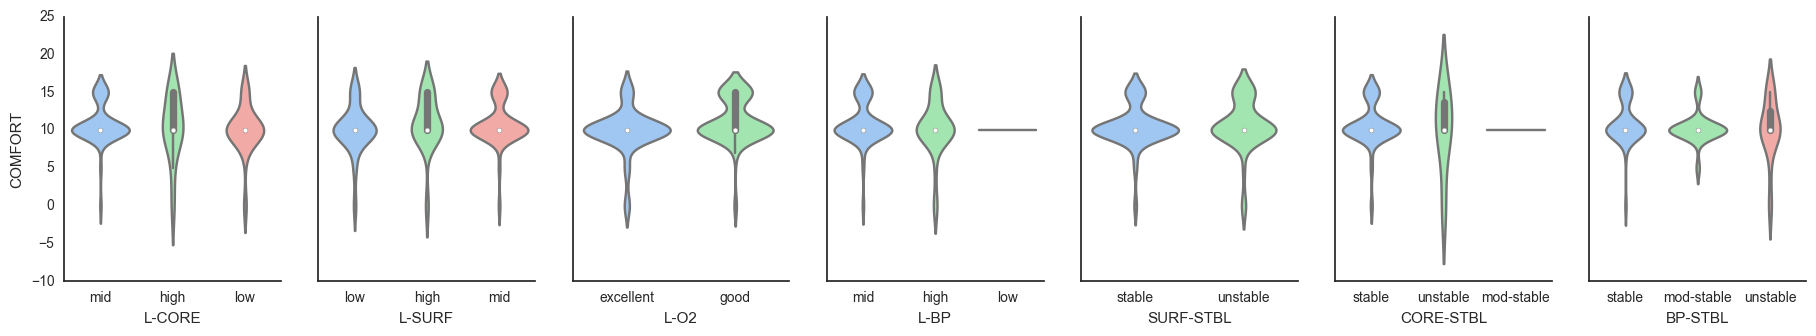

In [3]:
g = sns.PairGrid(Dataset,
                 x_vars=['L-CORE', 'L-SURF','L-O2','L-BP','SURF-STBL','CORE-STBL','BP-STBL'],
                 y_vars=['COMFORT'],
                 aspect=.75, size=3.5)
g.map(sns.violinplot, palette="pastel");

# Problem 2B: Counterplot

Do three features of choice and do a counterplot

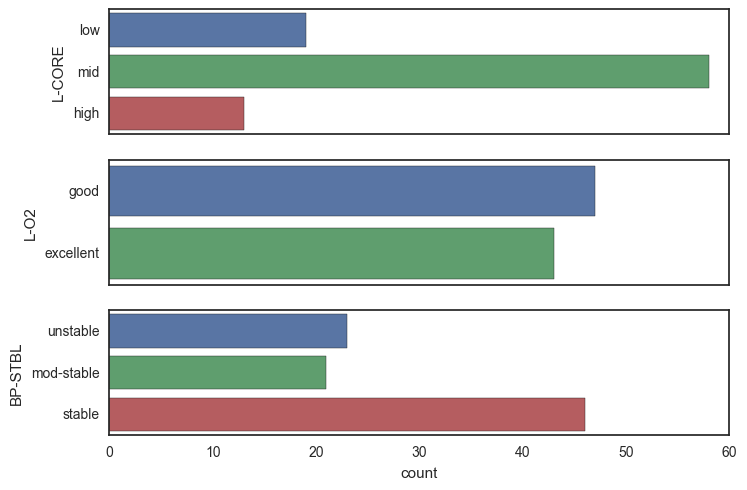

In [4]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0] = sns.countplot(data=Dataset, y='L-CORE',ax=axarr[0],order=['low','mid','high'])
axarr[0].set_xlabel('')
axarr[1] = sns.countplot(data=Dataset, y='L-O2',ax=axarr[1],order=['good','excellent'])
axarr[1].set_xlabel('')
axarr[2] = sns.countplot(data=Dataset, y='BP-STBL',ax=axarr[2],order=['unstable','mod-stable','stable'])

# Problem 3: Preprocess the Data

## 1. Check for missing values using missingno
The first step toward further proccessing the data is to check whether there are missing values in the dataset or not. I use missingno to show a graphical representation of data. According to missingno, there are no missing values in this dataset. 

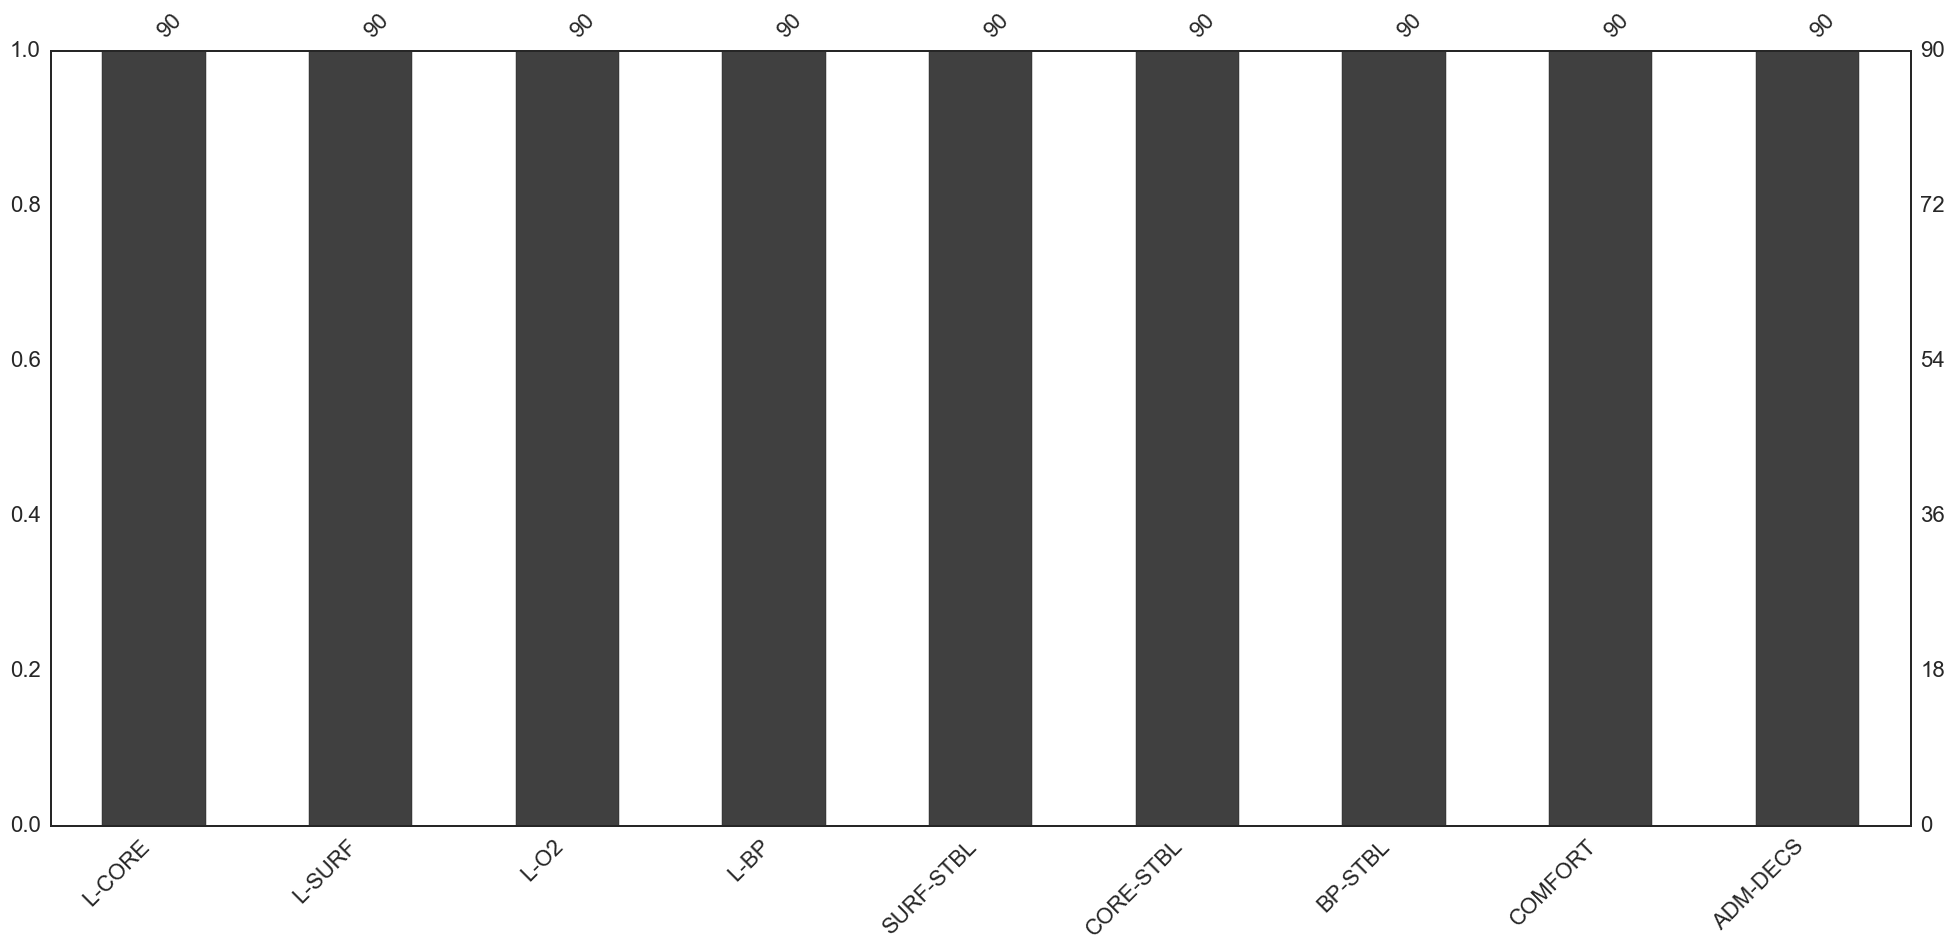

In [5]:
msno.bar(Dataset)

## 2.1. Converting Categorical Data to Numerical Data
Most of the datascience analysis requires numerical input, so we would like to convert all our categoriccal datas into numerical data. We have different categorical data in the feature section: "High Mid Low", "Excellent Good", or "Stable Unstable Mod-Stable". All of these are ordered features, so we can represent them in numeric format on a scale. I will represent Lower/Worse condition to 1 and highest to 3. 

The only special feature is L-O2, which is either "Excellent" or "Good". I am going to treat them as 1 (Good) and 2 (Excellent) even though these descritions are usually placed in Rank 4 or Rank 5 in a "Terrible Bad Fair Good Excellent" scale. This is because the actual number is not trivial in this problem, especially we are still going to do standardization (z-score) later on, and 4/5 has no different distribution compare to 1/2.

In [6]:
# Create a new object to prevent operation on the original dataset
Feature = Dataset.drop(labels=['ADM-DECS'],axis=1)

# Disabling a Chained-Assignment Warning: Pandas dislike overwriting Dataframe while referencing it.
pd.options.mode.chained_assignment = None

# Convert them to numbers
for label in Feature.columns:
    if Feature[label].dtype != 'int64':
        Feature[label][Dataset[label] == 'low'] = 1
        Feature[label][Dataset[label] == 'mid'] = 2
        Feature[label][Dataset[label] == 'high'] = 3
        Feature[label][Dataset[label] == 'good'] = 1
        Feature[label][Dataset[label] == 'excellent'] = 2
        Feature[label][Dataset[label] == 'stable'] = 3
        Feature[label][Dataset[label] == 'mod-stable'] = 2
        Feature[label][Dataset[label] == 'unstable'] = 1
        Feature[label] = pd.to_numeric(Feature[label])

Repeat the countplot again to make sure the result is still the same.

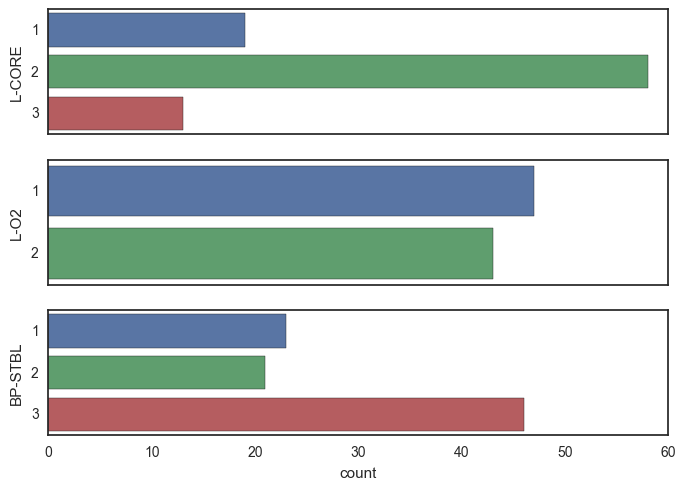

In [7]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0] = sns.countplot(data=Feature, y='L-CORE',ax=axarr[0])
axarr[0].set_xlabel('')
axarr[1] = sns.countplot(data=Feature, y='L-O2',ax=axarr[1])
axarr[1].set_xlabel('')
axarr[2] = sns.countplot(data=Feature, y='BP-STBL',ax=axarr[2])

## 2.2. Converting the class label
In this problem, we were asked to predict whether the patient will be discharge or not during post-operative area. We have three potential labels: I (patient sent to Intensive Care Unit), S (patient prepared to go home), A (patient sent to general hospital floor). We can rank I, S, and A base on severity: I=3, S=1, A=2. 

But still, this is probably not the best option because the actual severity may not be placed on a linear scale. A relatively generalize option is to develop Multi-class Prediction with 3 output nodes. I will do both options here, but which one is better (or more reasonable for real-life application) is still debatable. 

In [8]:
orderedLabel = Dataset['ADM-DECS'].copy()
for index in range(len(orderedLabel)):
    if strcmp(orderedLabel[index],'I'):
        orderedLabel[index] = 3
    elif strcmp(orderedLabel[index],'A'):
        orderedLabel[index] = 2
    elif strcmp(orderedLabel[index],'S'):
        orderedLabel[index] = 1
orderedLabel = pd.to_numeric(orderedLabel)

In [9]:
multiclassLabel = np.zeros((90,3))
for index in range(len(Dataset)):
    if strcmp(Dataset['ADM-DECS'][index],'I'):
        multiclassLabel[index,2] = 1
    elif strcmp(Dataset['ADM-DECS'][index],'A'):
        multiclassLabel[index,1] = 1
    elif strcmp(Dataset['ADM-DECS'][index],'S'):
        multiclassLabel[index,0] = 1
multiclassLabel = pd.DataFrame(multiclassLabel)

## 3. Normalization and Standardization
In this section, I will standardize everything in z-score. I use z-score instead of min-max scaler because I want to scale all features to have the same variance so even some features (such as L-O2) will weight the same as everything else even though its variance is higher. 

I do not think this dataseet (categorical data) should be normalized. Normalization is usually done with text-base classification that requires unit norm. In this case, an instance of three "high" feature shouldn't be normalized to the same as three "low" feature because all of them will have the unit norm. 

In [10]:
from sklearn import preprocessing
# z-score transform
#FeatureArray = np.array(Feature)
#preprocessedFeature = np.divide(np.subtract(FeatureArray, np.mean(FeatureArray,axis=0)),np.std(FeatureArray,axis=0))
scaler = preprocessing.StandardScaler().fit(Feature)
Feature_scaled = scaler.transform(Feature)
print(Feature_scaled)

[[ 0.11250879 -1.34516637  1.04547753 -0.57035183  1.          0.28497536
   0.88891945  1.47960502]
 [ 0.11250879  1.60763785  1.04547753  1.33082093  1.          0.28497536
   0.88891945 -0.19331523]
 [ 1.80014064 -1.34516637  1.04547753  1.33082093  1.          0.28497536
  -0.30515145 -0.19331523]
 [ 0.11250879 -1.34516637 -0.95650071  1.33082093  1.         -3.66083733
  -0.30515145  1.47960502]
 [ 0.11250879  0.13123574  1.04547753  1.33082093  1.          0.28497536
   0.88891945 -0.19331523]
 [ 1.80014064 -1.34516637 -0.95650071 -0.57035183  1.          0.28497536
  -1.49922235  1.47960502]
 [ 0.11250879 -1.34516637  1.04547753  1.33082093  1.          0.28497536
  -0.30515145 -1.86623548]
 [ 1.80014064  0.13123574  1.04547753 -0.57035183 -1.         -3.66083733
   0.88891945 -0.19331523]
 [ 0.11250879  1.60763785 -0.95650071 -0.57035183  1.          0.28497536
   0.88891945 -0.19331523]
 [ 0.11250879 -1.34516637  1.04547753 -0.57035183 -1.          0.28497536
  -0.30515145 -0.